In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import randint

# prep
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.preprocessing import binarize, LabelEncoder, MinMaxScaler

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Validation libraries
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error, precision_recall_curve
from sklearn.model_selection import cross_val_score


In [2]:
# Let's load our WHO suicide statistics

whs = pd.read_csv('who_suicide_statistics.csv')



In [3]:
# Let's drop the na
whsna = whs.dropna().shape[0]
whswna = whs.shape[0]
print(whsna/whswna)
whs.dropna(inplace=True)

0.8237390350877193


## EDA

Before analyzing correlations or feature importance, it's important to gain some familiarity with the dataset.
What we'll do next is ask ourselves interesting questions about what this dataset says on the geographic distribution of mental health.

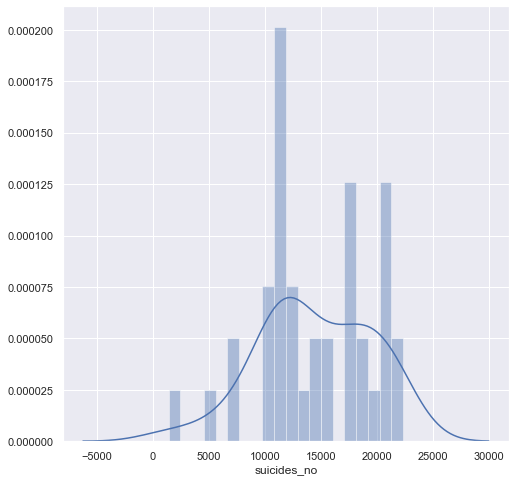

In [4]:
# There appears to be a normal distribution of suicides throughout Earth.

sns.set(rc={'figure.figsize':(8,8)})
sns.distplot( whs.groupby('year')["suicides_no"].max(), bins=20 )

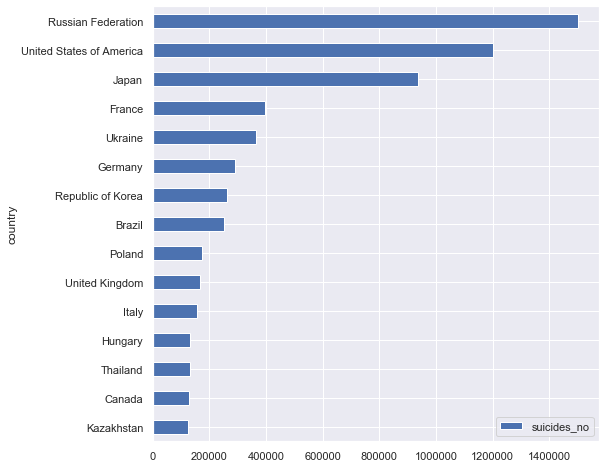

In [5]:
# What is the geographic distribution (top 15) of suicides among countries?
# You can change the amount of countries to graph inside the "tail()" parenthesis

whs.groupby(by=['country'])['suicides_no'].sum().reset_index().sort_values(['suicides_no'],ascending=True).tail(15).plot(x='country',y='suicides_no',kind='barh')

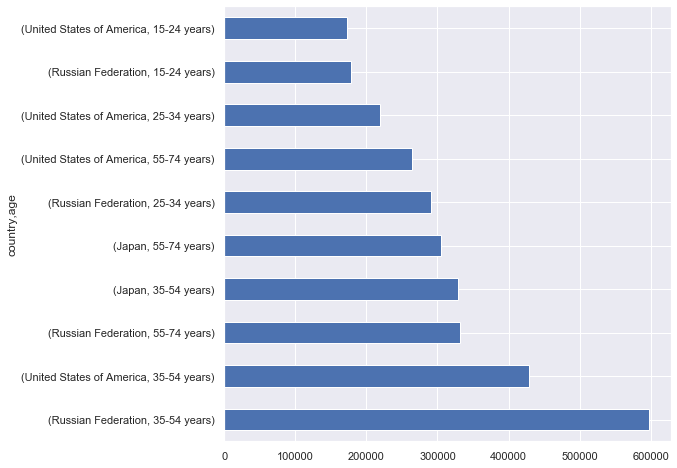

In [6]:
# What is the age range and country with the most frequent suicides?

whs.groupby(['country','age']).suicides_no.sum().nlargest(10).plot(kind='barh')

In [7]:
# Let's create a reduced dataset with a significant sample size

whs1000 = whs[whs['suicides_no']>1000]

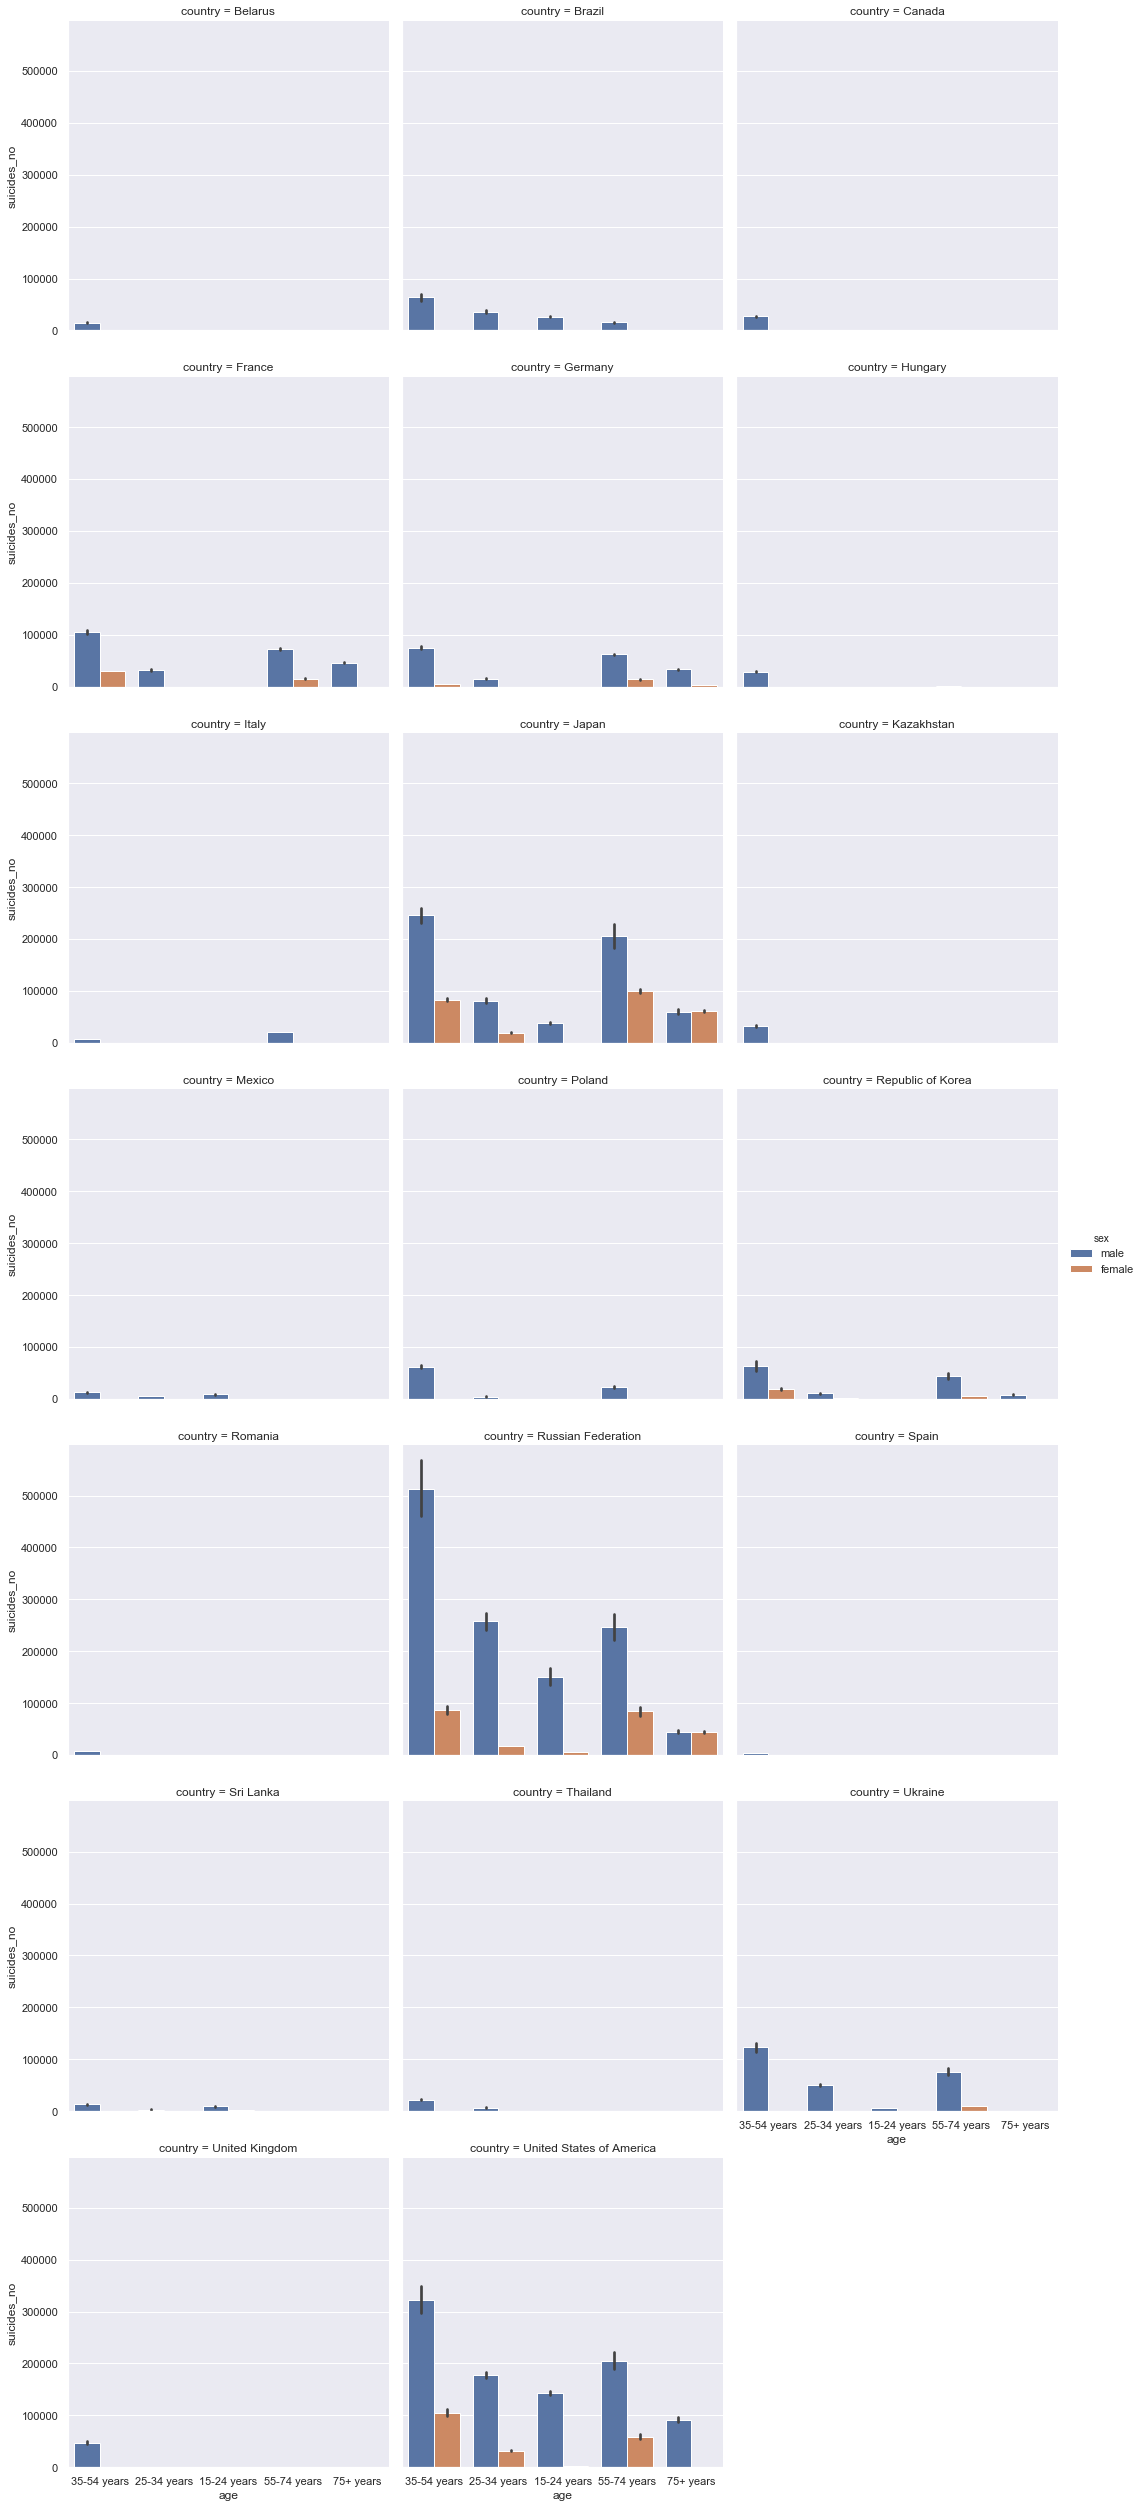

In [8]:
# Let's analyze gender distribution in age buckets for countries with frequency >1000 suicides

from numpy import sum

sns.catplot('age','suicides_no',hue='sex',col='country',data=whs1000,kind='bar',col_wrap=3,estimator=sum)

In [9]:
# Let's look at these figures in tabular form

whs1000.groupby(by=['country','age','sex'])['suicides_no'].sum().unstack()

sex                                     female      male
country                  age                            
Belarus                  35-54 years       NaN   14903.0
Brazil                   15-24 years       NaN   26053.0
                         25-34 years       NaN   36393.0
                         35-54 years       NaN   63705.0
                         55-74 years       NaN   15702.0
Canada                   35-54 years       NaN   27370.0
France                   25-34 years       NaN   32333.0
                         35-54 years   29840.0  105860.0
                         55-74 years   15143.0   72258.0
                         75+ years         NaN   46294.0
Germany                  25-34 years       NaN   15218.0
                         35-54 years    4430.0   74784.0
                         55-74 years   14565.0   62530.0
                         75+ years      3432.0   33042.0
Hungary                  35-54 years       NaN   28340.0
                         55-74 years       NaN    1009.0
Italy                    35-54 years       NaN    7856.0
                         55-74 years       NaN   20912.0
Japan                    15-24 years       NaN   38258.0
                         25-34 years   19571.0   81331.0
                         35-54 years   82850.0  245745.0
                         55-74 years   99943.0  205474.0
                         75+ years     60664.0   60117.0
Kazakhstan               35-54 years       NaN   32094.0
Mexico                   15-24 years       NaN    8566.0
                         25-34 years       NaN    5523.0
                         35-54 years       NaN   12800.0
Poland                   25-34 years       NaN    4382.0
                         35-54 years       NaN   62247.0
                         55-74 years       NaN   23238.0
Republic of Korea        25-34 years    1121.0   10750.0
                         35-54 years   18443.0   63919.0
                         55-74 years    5594.0   43915.0
                         75+ years         NaN    8181.0
Romania                  35-54 years       NaN    7464.0
Russian Federation       15-24 years    5217.0  151256.0
                         25-34 years   17693.0  257871.0
                         35-54 years   86469.0  511637.0
                         55-74 years   84628.0  246633.0
                         75+ years     43895.0   45050.0
Spain                    35-54 years       NaN    4389.0
Sri Lanka                15-24 years    2094.0    9376.0
                         25-34 years       NaN    3178.0
                         35-54 years       NaN   13072.0
Thailand                 25-34 years       NaN    6899.0
                         35-54 years       NaN   22308.0
Ukraine                  15-24 years       NaN    5296.0
                         25-34 years       NaN   50273.0
                         35-54 years       NaN  122995.0
                         55-74 years    9579.0   76080.0
United Kingdom           35-54 years       NaN   47645.0
United States of America 15-24 years    2133.0  143849.0
                         25-34 years   31681.0  177341.0
                         35-54 years  105365.0  322821.0
                         55-74 years   58509.0  204949.0
                         75+ years         NaN   91528.0

In [10]:
# Let's look at these figures in tabular form with a median estimator

whs1000.groupby(by=['country','age','sex'])['suicides_no'].median().unstack()

sex                                   female     male
country                  age                         
Belarus                  35-54 years     NaN   1264.5
Brazil                   15-24 years     NaN   1267.0
                         25-34 years     NaN   1431.0
                         35-54 years     NaN   1945.5
                         55-74 years     NaN   1253.5
Canada                   35-54 years     NaN   1242.5
France                   25-34 years     NaN   1346.0
                         35-54 years  1105.0   3032.5
                         55-74 years  1063.0   2007.5
                         75+ years       NaN   1324.0
Germany                  25-34 years     NaN   1452.0
                         35-54 years  1110.5   2969.0
                         55-74 years  1255.0   2411.5
                         75+ years    1153.0   1191.5
Hungary                  35-54 years     NaN   1222.0
                         55-74 years     NaN   1009.0
Italy                    35-54 years     NaN   1123.0
                         55-74 years     NaN   1078.0
Japan                    15-24 years     NaN   1242.0
                         25-34 years  1086.5   2319.0
                         35-54 years  2237.0   6688.0
                         55-74 years  2636.0   5241.0
                         75+ years    1649.0   1554.5
Kazakhstan               35-54 years     NaN   1225.0
Mexico                   15-24 years     NaN   1251.0
                         25-34 years     NaN   1140.0
                         35-54 years     NaN   1267.5
Poland                   25-34 years     NaN   1078.5
                         35-54 years     NaN   2141.0
                         55-74 years     NaN   1163.0
Republic of Korea        25-34 years  1121.0   1210.0
                         35-54 years  1500.0   2902.0
                         55-74 years  1152.0   2627.0
                         75+ years       NaN   1152.0
Romania                  35-54 years     NaN   1059.0
Russian Federation       15-24 years  1054.0   4641.0
                         25-34 years  1097.0   7715.0
                         35-54 years  2568.0  15357.5
                         55-74 years  2921.5   6481.5
                         75+ years    1409.5   1364.0
Spain                    35-54 years     NaN   1095.0
Sri Lanka                15-24 years  1047.0   1386.0
                         25-34 years     NaN   1045.0
                         35-54 years     NaN   1483.0
Thailand                 25-34 years     NaN   1142.5
                         35-54 years     NaN   1234.0
Ukraine                  15-24 years     NaN   1054.0
                         25-34 years     NaN   1559.5
                         35-54 years     NaN   3883.0
                         55-74 years  1029.0   2070.0
United Kingdom           35-54 years     NaN   1314.0
United States of America 15-24 years  1066.5   3981.0
                         25-34 years  1240.0   4906.0
                         35-54 years  2674.0   8920.0
                         55-74 years  1536.0   4989.0
                         75+ years       NaN   2566.0

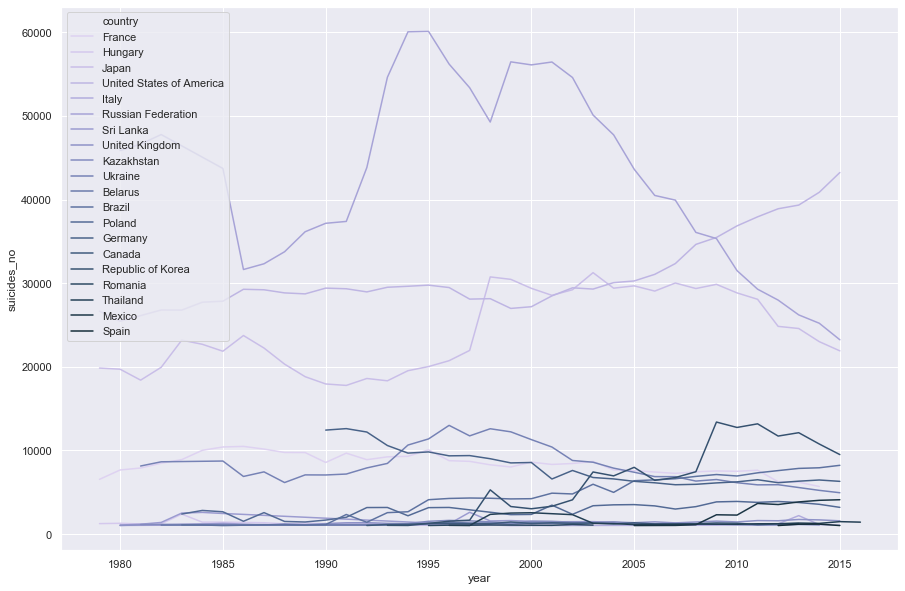

In [11]:
# Let's analyze the evolution of these countries throughout the years

from matplotlib.colors import LogNorm
df = whs1000.groupby(['year','country']).suicides_no.sum().reset_index()
sns.set(rc={'figure.figsize':(15,10)})
sns.lineplot('year','suicides_no',hue='country',data=df,hue_norm=LogNorm(),palette="ch:2.5,.25",sort=False)

In [12]:
pd.options.display.max_rows = 200
#wh.pivot_table(index='country',columns='year',values=['suicides_no'], aggfunc=['sum']).count()
pivot_table=whs1000.pivot_table(index='country',columns='year',values=['suicides_no'], aggfunc=['sum'])
pivot_table

sum                                      \
                         suicides_no                                       
year                            1979     1980     1981     1982     1983   
country                                                                    
Belarus                          NaN      NaN      NaN   1071.0      NaN   
Brazil                           NaN      NaN      NaN      NaN   1090.0   
Canada                           NaN      NaN      NaN      NaN      NaN   
France                        6540.0   7659.0   7896.0   8471.0   8900.0   
Germany                          NaN      NaN      NaN      NaN      NaN   
Hungary                       1246.0   1282.0   1204.0   1222.0   2381.0   
Italy                            NaN   1026.0      NaN   1054.0   1125.0   
Japan                        19850.0  19715.0  18405.0  19940.0  23189.0   
Kazakhstan                       NaN      NaN   1138.0   1138.0      NaN   
Mexico                           NaN      NaN      NaN      NaN      NaN   
Poland                           NaN      NaN      NaN      NaN   2390.0   
Republic of Korea                NaN      NaN      NaN      NaN      NaN   
Romania                          NaN      NaN      NaN      NaN      NaN   
Russian Federation               NaN  45859.0  46640.0  47776.0      NaN   
Spain                            NaN      NaN      NaN      NaN      NaN   
Sri Lanka                        NaN   1079.0   1174.0   1386.0   2507.0   
Thailand                         NaN      NaN      NaN      NaN      NaN   
Ukraine                          NaN      NaN   8136.0   8639.0      NaN   
United Kingdom                   NaN   1027.0   1090.0   1127.0   1168.0   
United States of America     26653.0  25457.0  26123.0  26795.0  26783.0   

                                                                       ...  \
                                                                       ...   
year                         1984     1985     1986     1987     1988  ...   
country                                                                ...   
Belarus                       NaN      NaN      NaN      NaN      NaN  ...   
Brazil                     1082.0   1011.0      NaN   1100.0   1115.0  ...   
Canada                        NaN      NaN      NaN      NaN      NaN  ...   
France                    10013.0  10412.0  10482.0  10159.0   9755.0  ...   
Germany                       NaN      NaN      NaN      NaN      NaN  ...   
Hungary                    1420.0   1421.0   1392.0   1351.0   1218.0  ...   
Italy                      1166.0   1307.0   1164.0   1146.0   1073.0  ...   
Japan                     22693.0  21864.0  23742.0  22243.0  20320.0  ...   
Kazakhstan                    NaN   1071.0      NaN      NaN      NaN  ...   
Mexico                        NaN      NaN      NaN      NaN      NaN  ...   
Poland                     2822.0   2660.0   1525.0   2561.0   1505.0  ...   
Republic of Korea             NaN      NaN      NaN      NaN      NaN  ...   
Romania                       NaN      NaN      NaN      NaN      NaN  ...   
Russian Federation            NaN  43725.0  31637.0  32324.0  33762.0  ...   
Spain                         NaN      NaN      NaN      NaN      NaN  ...   
Sri Lanka                  2588.0   2456.0   2349.0      NaN      NaN  ...   
Thailand                      NaN      NaN      NaN      NaN      NaN  ...   
Ukraine                       NaN   8730.0   6886.0   7434.0   6158.0  ...   
United Kingdom             1200.0   1208.0   1152.0   1072.0   1218.0  ...   
United States of America  27725.0  27848.0  29272.0  29213.0  28840.0  ...   

                                                                       \
                                                                        
year                         2007     2008     2009     2010     2011   
country                                                                 
Belarus                       NaN      NaN 

In [13]:
pivot_table_pct_change = pivot_table.pct_change(axis='columns')
pivot_table_pct_change.columns = pivot_table_pct_change.columns.droplevel().droplevel()
pivot_table_pct_change

year,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
country,,,,,,,,,,,,,,,,,,,,,
Belarus,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Brazil,NaN,NaN,NaN,NaN,NaN,-0.007339,-0.065619,0.000000,0.088032,0.013636,...,0.020685,0.042498,0.032352,-0.024452,0.054307,0.036480,0.034537,0.009684,0.036976,0.000000
Canada,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.018303,0.013889,0.070105,-0.027108,-0.127709,0.069210,0.032365,0.000000,0.000000,0.000000
France,NaN,0.171101,0.030944,0.072822,0.050643,0.125056,0.039848,0.006723,-0.030815,-0.039768,...,-0.021845,0.025503,0.014518,-0.005963,0.017462,-0.180270,-0.009589,-0.082621,0.000000,0.000000
Germany,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.037865,0.008651,0.028254,0.020608,0.040705,-0.054512,0.029316,0.022468,-0.025070,0.000000
Hungary,NaN,0.028892,-0.060842,0.014950,0.948445,-0.403612,0.000704,-0.020408,-0.029454,-0.098446,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Italy,NaN,NaN,0.000000,0.027290,0.067362,0.036444,0.120926,-0.109411,-0.015464,-0.063700,...,0.000000,0.000000,0.048563,0.037807,0.035519,0.068602,0.811523,-0.489777,-0.053428,0.000000
Japan,NaN,-0.006801,-0.066447,0.083401,0.162939,-0.021389,-0.036531,0.085895,-0.063137,-0.086454,...,0.033211,-0.021984,0.017063,-0.034256,-0.026491,-0.115365,-0.010267,-0.063990,-0.047807,0.000000
Kazakhstan,NaN,NaN,NaN,0.000000,0.000000,0.000000,-0.058875,0.000000,0.000000,0.000000,...,0.040816,-0.076078,0.002547,-0.053345,-0.050089,0.011299,0.063315,-0.052539,0.000000,0.000000


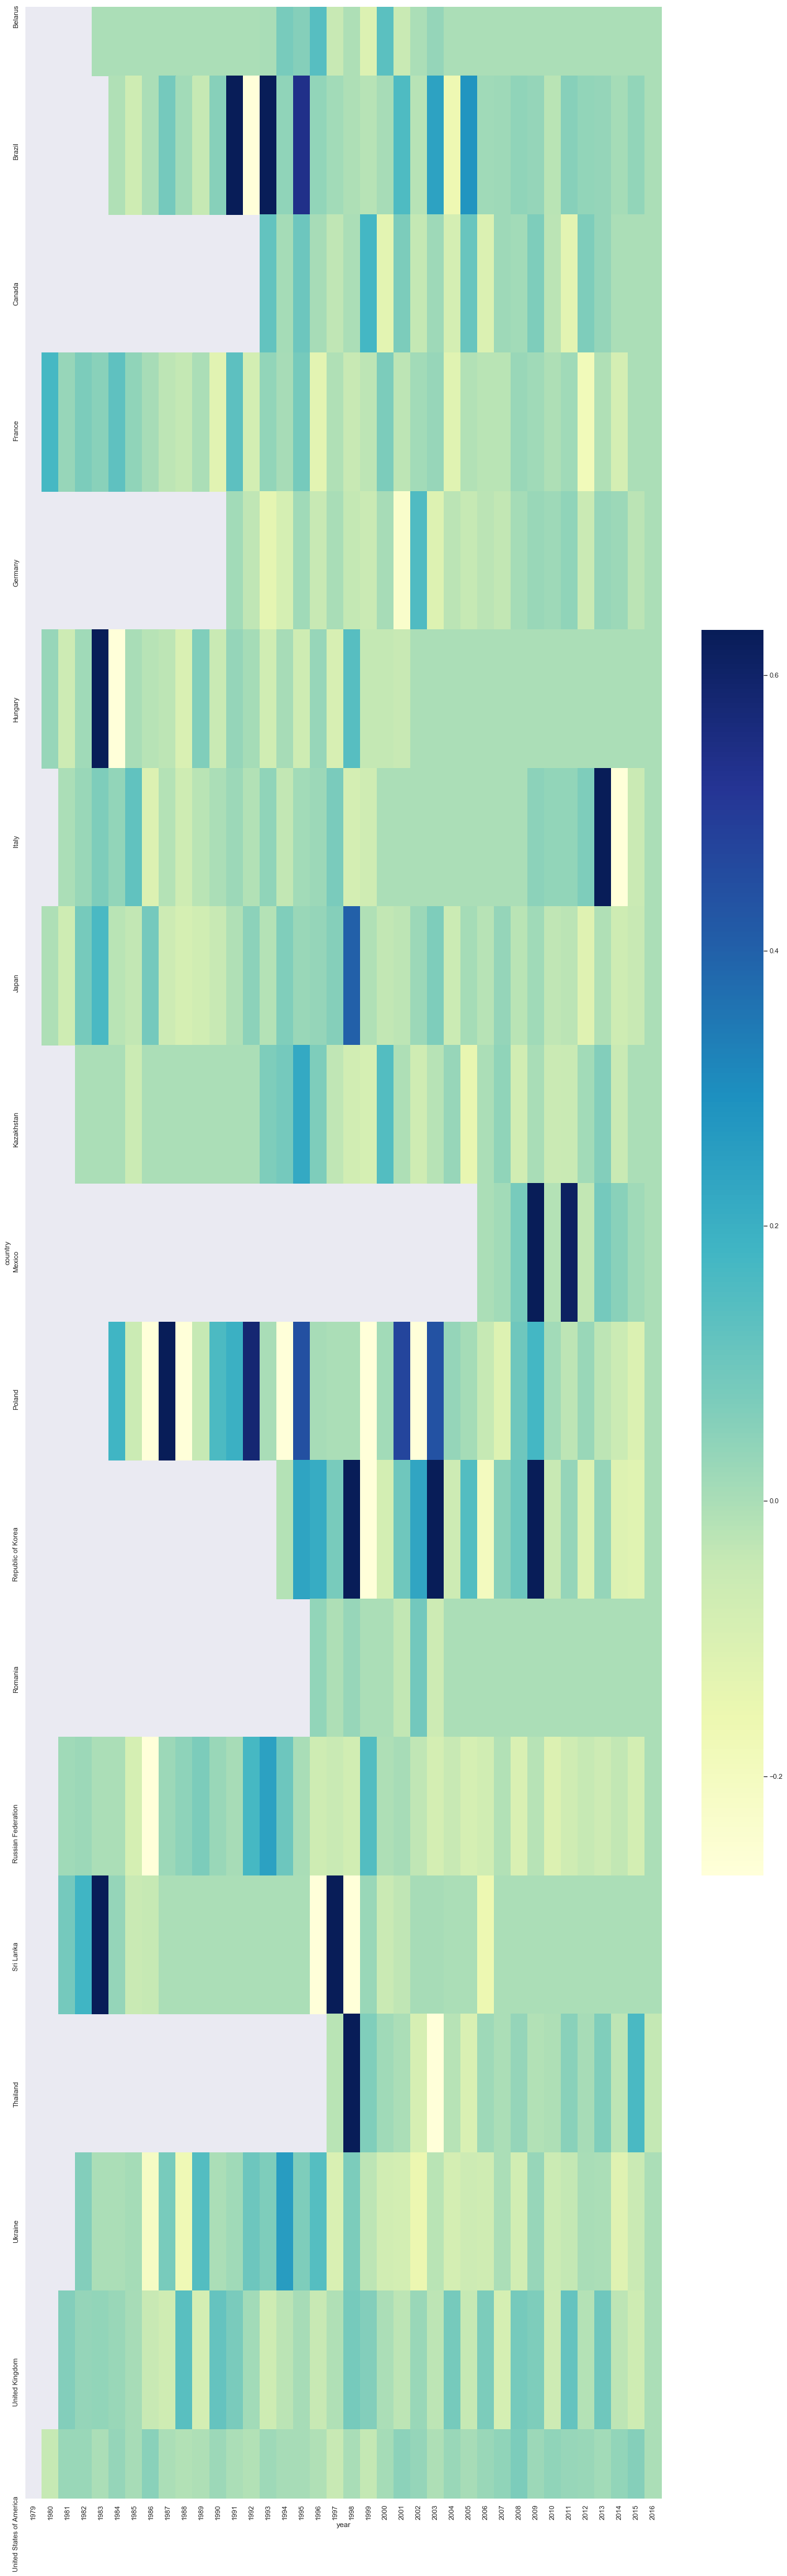

In [14]:
# Let's see the percent change over the years per country
sns.set(rc={'figure.figsize':(23,74)})
sns.heatmap(pivot_table_pct_change.dropna(axis=0,thresh=10), cmap="YlGnBu",robust=True,cbar_kws={"shrink": 0.5})
plt.xticks(rotation=90) 
plt.show()

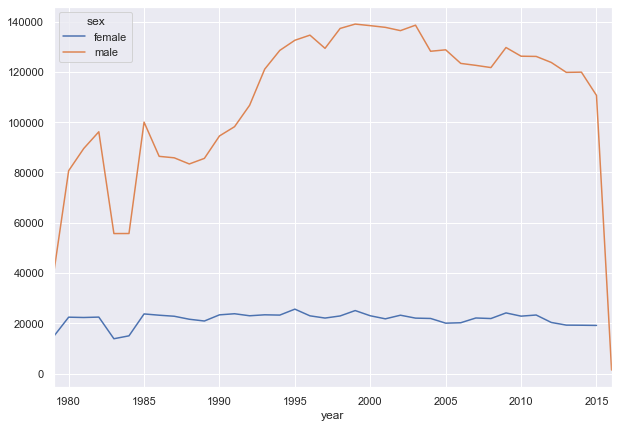

In [15]:
# Lastly, how does gender influence statistics over the years?

sns.set(rc={'figure.figsize':(10,7)})
whs1000.pivot_table(index='year',columns='sex',values='suicides_no', aggfunc='sum').plot()

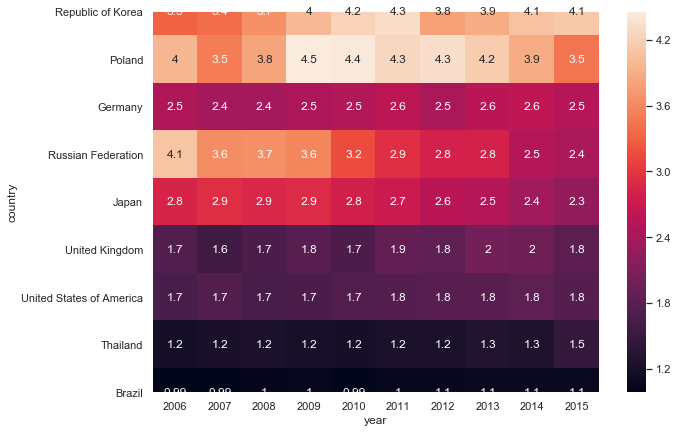

In [16]:
# Is there a relationship in the suicide/population ratio over the years?

# Suicides

p = pd.crosstab(index=whs1000.country,columns=whs1000.year,values=whs1000.suicides_no,aggfunc='sum')

#sns.heatmap(p.loc[:,2011:2015].sort_values(2015, ascending=False).dropna().head(5),annot=True)

# Population

pp = pd.crosstab(index=whs1000.country,columns=whs1000.year,values=whs1000.population,aggfunc='sum')

pdivpp = p/pp*10000

# Tamper with the number of countries you'd like to see inside the "head()" parenthesis

sns.heatmap(pdivpp.loc[:,2006:2015].sort_values(2015, ascending=False).dropna().head(10),annot=True)

## Happiness Worldwide

In [17]:
happiness = pd.read_csv('world-happiness2015.csv')
happiness.head()

,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Switzerland,Western Europe,1,7.587,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738
1,Iceland,Western Europe,2,7.561,0.04884,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201
2,Denmark,Western Europe,3,7.527,0.03328,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204
3,Norway,Western Europe,4,7.522,0.03880,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531
4,Canada,North America,5,7.427,0.03553,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176


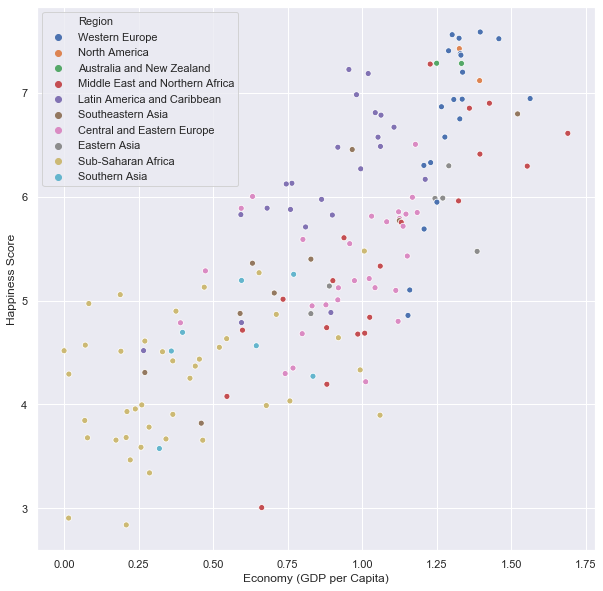

In [18]:
# Who are the happiest regions?

sns.set(rc={'figure.figsize':(10,10)})
#g = sns.FacetGrid(happiness, col="Region",  margin_titles=True, col_wrap=3)

#(g.map(plt.scatter, "Generosity","Happiness Score", edgecolor="w")).add_legend()
sns.scatterplot("Economy (GDP per Capita)","Happiness Score",hue='Region', data=happiness)

## Feature Correlation

Now that we have a general idea of how our data is distributed, let's use a statistical operator to measure the tendency of dispersion between quantitative values.

## Perason Correlation

We'll be using the Pearson Correlation coefficient, which is a statistic that measures linear correlation between two variables X and Y. It has a value between +1 and −1, where 1 is total positive linear correlation, 0 is no linear correlation, and −1 is total negative linear correlation (that the value lies between -1 and 1 is a consequence of the Cauchy–Schwarz inequality) . It is widely used in the sciences.

https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

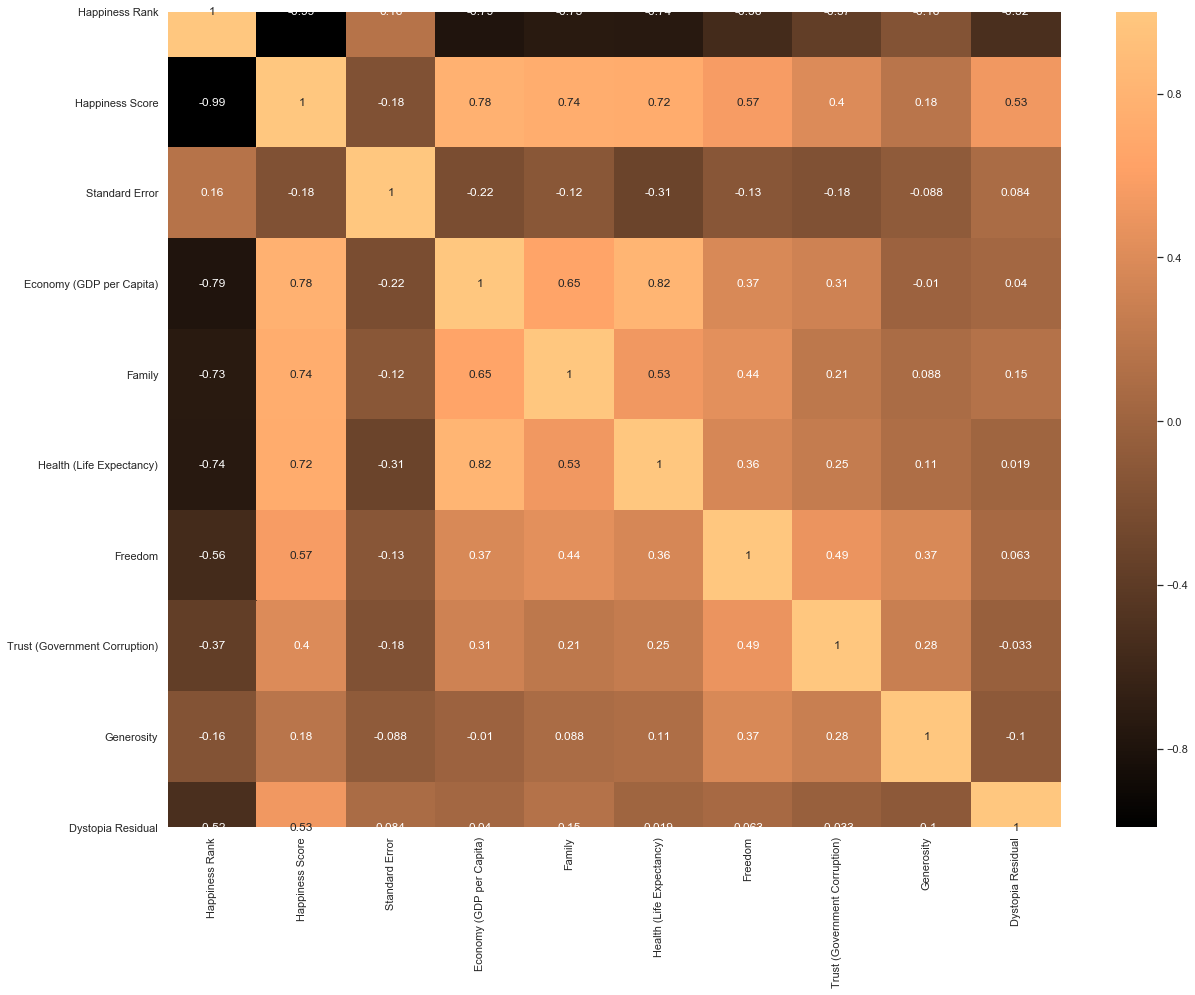

In [19]:
# Let's analyze all of our factors

plt.rcParams['figure.figsize'] = (20, 15)
sns.heatmap(happiness.corr(), cmap = 'copper', annot = True)

plt.show()

In [20]:
# Let's merge now an analyze feature importance!

whs.country.values

array(['Albania', 'Albania', 'Albania', ..., 'Virgin Islands (USA)',
       'Virgin Islands (USA)', 'Virgin Islands (USA)'], dtype=object)

In [21]:
happiness.Country.values

array(['Switzerland', 'Iceland', 'Denmark', 'Norway', 'Canada', 'Finland',
       'Netherlands', 'Sweden', 'New Zealand', 'Australia', 'Israel',
       'Costa Rica', 'Austria', 'Mexico', 'United States', 'Brazil',
       'Luxembourg', 'Ireland', 'Belgium', 'United Arab Emirates',
       'United Kingdom', 'Oman', 'Venezuela', 'Singapore', 'Panama',
       'Germany', 'Chile', 'Qatar', 'France', 'Argentina',
       'Czech Republic', 'Uruguay', 'Colombia', 'Thailand',
       'Saudi Arabia', 'Spain', 'Malta', 'Taiwan', 'Kuwait', 'Suriname',
       'Trinidad and Tobago', 'El Salvador', 'Guatemala', 'Uzbekistan',
       'Slovakia', 'Japan', 'South Korea', 'Ecuador', 'Bahrain', 'Italy',
       'Bolivia', 'Moldova', 'Paraguay', 'Kazakhstan', 'Slovenia',
       'Lithuania', 'Nicaragua', 'Peru', 'Belarus', 'Poland', 'Malaysia',
       'Croatia', 'Libya', 'Russia', 'Jamaica', 'North Cyprus', 'Cyprus',
       'Algeria', 'Kosovo', 'Turkmenistan', 'Mauritius', 'Hong Kong',
       'Estonia', 'Indonesi

In [22]:
comp = whs.merge(happiness,how='inner',left_on='country',right_on='Country')

In [23]:
comp.shape

(27264, 18)

In [24]:
comp.head()

,country,year,sex,age,suicides_no,population,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Albania,1987,female,15-24 years,14.0,289700.0,Albania,Central and Eastern Europe,95,4.959,0.05013,0.87867,0.80434,0.81325,0.35733,0.06413,0.14272,1.89894
1,Albania,1987,female,25-34 years,4.0,257200.0,Albania,Central and Eastern Europe,95,4.959,0.05013,0.87867,0.80434,0.81325,0.35733,0.06413,0.14272,1.89894
2,Albania,1987,female,35-54 years,6.0,278800.0,Albania,Central and Eastern Europe,95,4.959,0.05013,0.87867,0.80434,0.81325,0.35733,0.06413,0.14272,1.89894
3,Albania,1987,female,5-14 years,0.0,311000.0,Albania,Central and Eastern Europe,95,4.959,0.05013,0.87867,0.80434,0.81325,0.35733,0.06413,0.14272,1.89894
4,Albania,1987,female,55-74 years,0.0,144600.0,Albania,Central and Eastern Europe,95,4.959,0.05013,0.87867,0.80434,0.81325,0.35733,0.06413,0.14272,1.89894


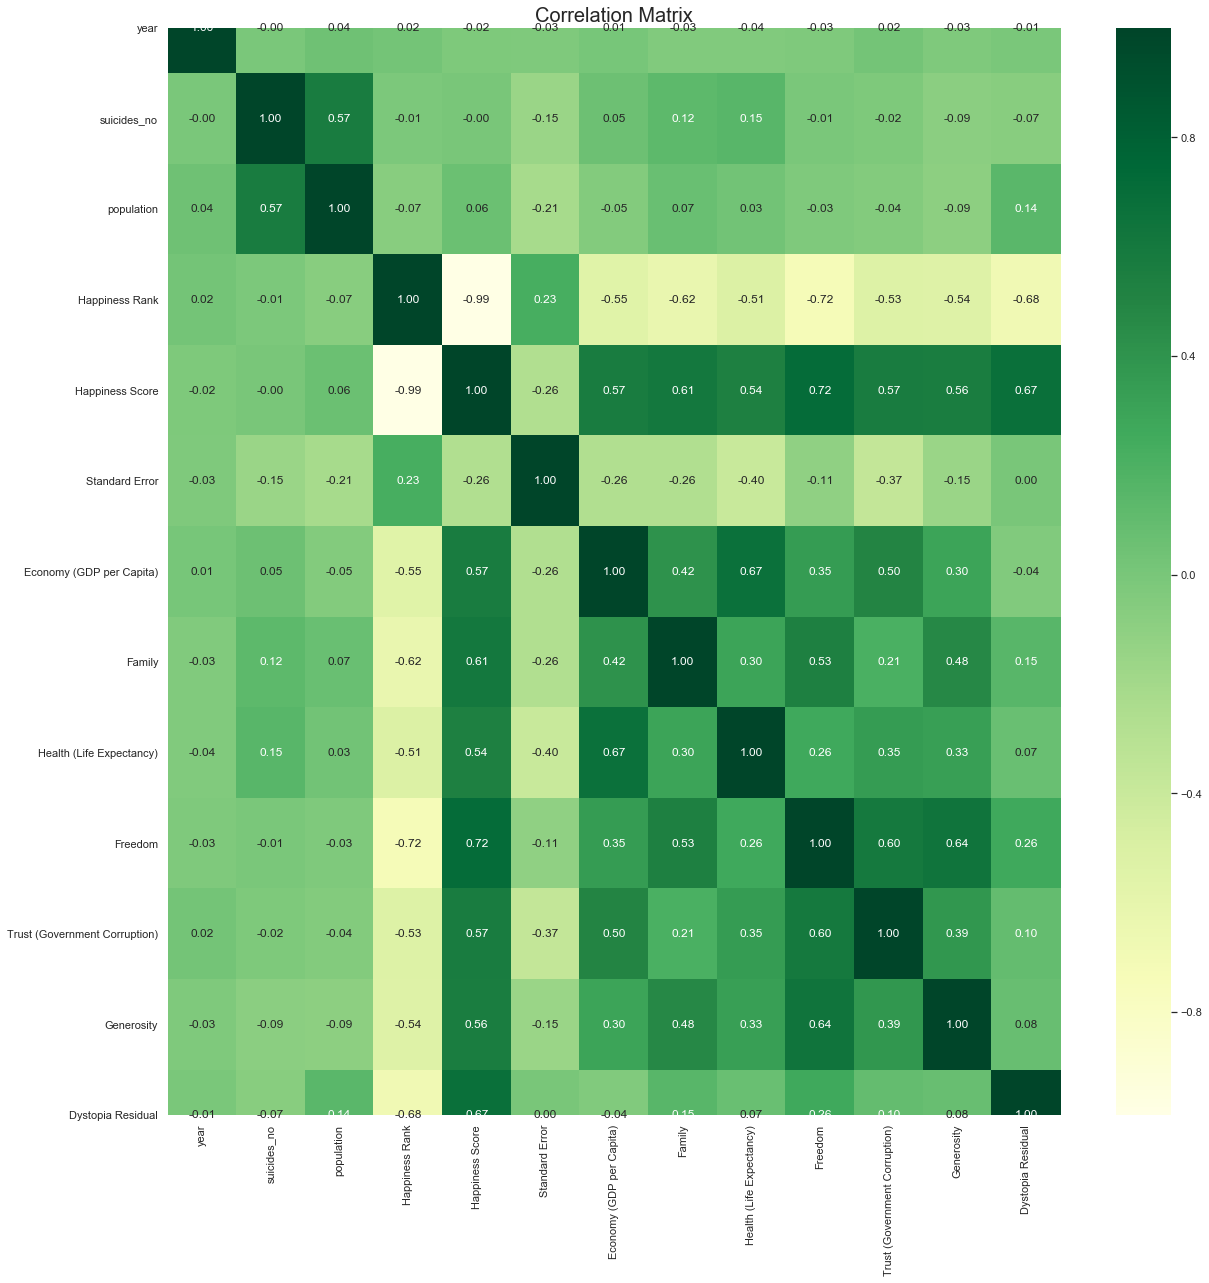

In [25]:
# Correlation External Features (Temp)

plt.figure(figsize=(20,20))
cm= comp.corr()
hm = sns.heatmap(cm, annot=True, fmt='.2f', cmap="YlGn")
hm.set_title('Correlation Matrix', fontsize=20, y=1.02)

#plt.savefig("corr.png")

plt.show()

## Results

One would think Happiness or the Economy is the most imoportant factor in suicidal behavior, but 
* population size
* life expectancy
* Family

seem to be a lot more relevant

In [26]:
cm['suicides_no'].sort_values(ascending=False)

suicides_no                      1.000000
population                       0.565751
Health (Life Expectancy)         0.145585
Family                           0.123449
Economy (GDP per Capita)         0.054266
Happiness Score                 -0.000306
year                            -0.003275
Freedom                         -0.005633
Happiness Rank                  -0.013292
Trust (Government Corruption)   -0.022978
Dystopia Residual               -0.069009
Generosity                      -0.085041
Standard Error                  -0.150089
Name: suicides_no, dtype: float64

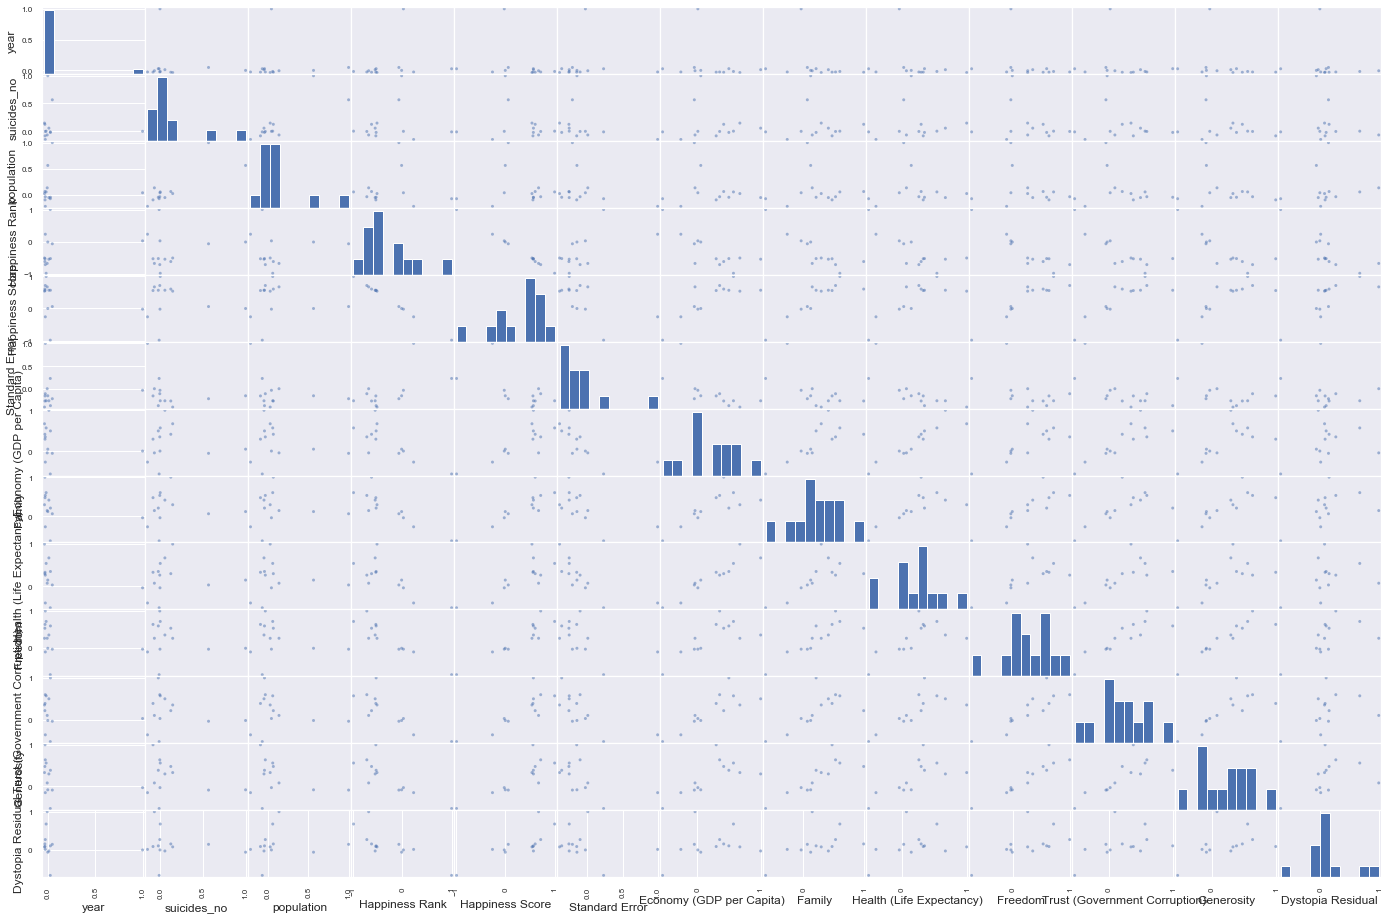

In [27]:
from pandas.plotting import scatter_matrix
scatter_matrix(cm, figsize = (24,16));

In [28]:
# Will Temperature affect this?

temp = pd.read_csv('GlobalLandTemperaturesByCountry.csv')

In [29]:
temp['year'] = temp['dt'].str[:4]
temp['year'] = pd.to_numeric(temp['year'], errors='ignore')

In [30]:
tempdf=temp.groupby(by=['Country'])['AverageTemperature'].mean().to_frame()

In [31]:
tempdf.head()

,AverageTemperature
Country,
Afghanistan,14.045007
Africa,24.074203
Albania,12.610646
Algeria,22.985112
American Samoa,26.611965


In [32]:
tcomp = comp.merge(tempdf,how='inner',left_on='country',right_on='Country')

In [33]:
# Correlation External Features (Temp)
tcm= tcomp.corr()

# No.

tcm['suicides_no'].sort_values(ascending=False)

suicides_no                      1.000000
population                       0.564544
Health (Life Expectancy)         0.140506
Family                           0.123011
Economy (GDP per Capita)         0.055223
Happiness Score                 -0.001875
year                            -0.005664
Freedom                         -0.006523
Happiness Rank                  -0.012691
Trust (Government Corruption)   -0.030321
AverageTemperature              -0.063303
Dystopia Residual               -0.068749
Generosity                      -0.082268
Standard Error                  -0.147053
Name: suicides_no, dtype: float64

## Tech Survey

Let's analyze our tech survey now.

This survey comes in the form of qualitative data except for the age of participants.
After null treatment, we will have to choose some sort of encoding for these qualitative observations.

In [34]:
train_df = pd.read_csv('survey.csv')

In [35]:
#dealing with missing data
#Let’s get rid of the variables "Timestamp",“comments”, “state” just to make our lives easier.
train_df = train_df.drop(['comments'], axis= 1)
train_df = train_df.drop(['state'], axis= 1)
train_df = train_df.drop(['Timestamp'], axis= 1)

train_df.isnull().sum().max() #just checking that there's no missing data missing...
train_df.head(5)

,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,Female,United States,NaN,No,Yes,Often,6-25,No,Yes,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,M,United States,NaN,No,No,Rarely,More than 1000,No,No,...,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,Male,Canada,NaN,No,No,Rarely,6-25,No,Yes,...,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,Male,United Kingdom,NaN,Yes,Yes,Often,26-100,No,Yes,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,Male,United States,NaN,No,No,Never,100-500,Yes,Yes,...,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


In [36]:
# Assign default values for each data type
defaultInt = 0
defaultString = 'NaN'
defaultFloat = 0.0

# Create lists by data tpe
intFeatures = ['Age']
stringFeatures = ['Gender', 'Country', 'self_employed', 'family_history', 'treatment', 'work_interfere',
                 'no_employees', 'remote_work', 'tech_company', 'anonymity', 'leave', 'mental_health_consequence',
                 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview',
                 'mental_vs_physical', 'obs_consequence', 'benefits', 'care_options', 'wellness_program',
                 'seek_help']
floatFeatures = []

# Clean the NaN's
for feature in train_df:
    if feature in intFeatures:
        train_df[feature] = train_df[feature].fillna(defaultInt)
    elif feature in stringFeatures:
        train_df[feature] = train_df[feature].fillna(defaultString)
    elif feature in floatFeatures:
        train_df[feature] = train_df[feature].fillna(defaultFloat)
    else:
        print('Error: Feature %s not recognized.' % feature)
train_df.head(5)   

,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,Female,United States,NaN,No,Yes,Often,6-25,No,Yes,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,M,United States,NaN,No,No,Rarely,More than 1000,No,No,...,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,Male,Canada,NaN,No,No,Rarely,6-25,No,Yes,...,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,Male,United Kingdom,NaN,Yes,Yes,Often,26-100,No,Yes,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,Male,United States,NaN,No,No,Never,100-500,Yes,Yes,...,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


## Cleaning "Gender"

Gender was a free-text field and it generated variations that aren't relevant to our statistical analysis.
Let's reduce our genders to male, female, or trans.

In [37]:
#clean 'Gender'
#Slower case all columm's elements
gender = train_df['Gender'].str.lower()
#print(gender)

#Select unique elements
gender = train_df['Gender'].unique()

#Made gender groups
male_str = ["male", "m", "male-ish", "maile", "mal", "male (cis)", "make", "male ", "man","msle", "mail", "malr","cis man", "Cis Male", "cis male"]
trans_str = ["trans-female", "something kinda male?", "queer/she/they", "non-binary","nah", "all", "enby", "fluid", "genderqueer", "androgyne", "agender", "male leaning androgynous", "guy (-ish) ^_^", "trans woman", "neuter", "female (trans)", "queer", "ostensibly male, unsure what that really means"]           
female_str = ["cis female", "f", "female", "woman",  "femake", "female ","cis-female/femme", "female (cis)", "femail"]

for (row, col) in train_df.iterrows():

    if str.lower(col.Gender) in male_str:
        train_df['Gender'].replace(to_replace=col.Gender, value='male', inplace=True)

    if str.lower(col.Gender) in female_str:
        train_df['Gender'].replace(to_replace=col.Gender, value='female', inplace=True)

    if str.lower(col.Gender) in trans_str:
        train_df['Gender'].replace(to_replace=col.Gender, value='trans', inplace=True)

#Get rid of the diversity
stk_list = ['A little about you', 'p']
train_df = train_df[~train_df['Gender'].isin(stk_list)]

print(train_df['Gender'].unique())

['female' 'male' 'trans']


In [38]:
#complete missing age with mean
train_df['Age'].fillna(train_df['Age'].median(), inplace = True)

# Fill with media() values < 18 and > 120
s = pd.Series(train_df['Age'])
s[s<18] = train_df['Age'].median()
train_df['Age'] = s
s = pd.Series(train_df['Age'])
s[s>120] = train_df['Age'].median()
train_df['Age'] = s

#Ranges of Age
train_df['age_range'] = pd.cut(train_df['Age'], [0,20,30,65,100], labels=["0-20", "21-30", "31-65", "66-100"], include_lowest=True)

In [39]:
#There are only 0.014% of self employed so let's change NaN to NOT self_employed
#Replace "NaN" string from defaultString
train_df['self_employed'] = train_df['self_employed'].replace([defaultString], 'No')
print(train_df['self_employed'].unique())

['No' 'Yes']


In [40]:
#There are only 0.20% of self work_interfere so let's change NaN to "Don't know
#Replace "NaN" string from defaultString

train_df['work_interfere'] = train_df['work_interfere'].replace([defaultString], 'Don\'t know' )
print(train_df['work_interfere'].unique())

df_co =train_df.copy()

['Often' 'Rarely' 'Never' 'Sometimes' "Don't know"]


## Label Encoding

We are going to turn our quantitative features into something that can be vectorized and process by a machine learning algo.

Label Encoding is a simple ordinal way of vectorizing which provides a # to each in the feature.
There are numerous types of encoders, but for a benchmark -- which will help us determine feature importance, this one will work.

Here's a great example of what encoding is and how "Label Encoding" compares to "One Hot Encoding":

https://towardsdatascience.com/choosing-the-right-encoding-method-label-vs-onehot-encoder-a4434493149b

In [41]:
from sklearn import preprocessing
#Encoding data
labelDict = {}
for feature in train_df:
    le = preprocessing.LabelEncoder()
    le.fit(train_df[feature])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    train_df[feature] = le.transform(train_df[feature])
    # Get labels
    labelKey = 'label_' + feature
    labelValue = [*le_name_mapping]
    labelDict[labelKey] =labelValue
    
for key, value in labelDict.items():     
    print(key, value)

#Get rid of 'Country'
df_corr = train_df.copy()
#train_df = train_df.drop(['Country'], axis= 1)
#train_df.head()

label_Age [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 60, 61, 62, 65, 72]
label_Gender ['female', 'male', 'trans']
label_Country ['Australia', 'Austria', 'Belgium', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Canada', 'China', 'Colombia', 'Costa Rica', 'Croatia', 'Czech Republic', 'Denmark', 'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'India', 'Ireland', 'Israel', 'Italy', 'Japan', 'Latvia', 'Mexico', 'Moldova', 'Netherlands', 'New Zealand', 'Nigeria', 'Norway', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Russia', 'Singapore', 'Slovenia', 'South Africa', 'Spain', 'Sweden', 'Switzerland', 'Thailand', 'United Kingdom', 'United States', 'Uruguay', 'Zimbabwe']
label_self_employed ['No', 'Yes']
label_family_history ['No', 'Yes']
label_treatment ['No', 'Yes']
label_work_interfere ["Don't know", 'Never', 'Often', 'Rarely', 'Sometimes']
label_no_emp

In [42]:
#missing data
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)
print(missing_data)

                           Total  Percent
age_range                      0      0.0
care_options                   0      0.0
Gender                         0      0.0
Country                        0      0.0
self_employed                  0      0.0
family_history                 0      0.0
treatment                      0      0.0
work_interfere                 0      0.0
no_employees                   0      0.0
remote_work                    0      0.0
tech_company                   0      0.0
benefits                       0      0.0
wellness_program               0      0.0
obs_consequence                0      0.0
seek_help                      0      0.0
anonymity                      0      0.0
leave                          0      0.0
mental_health_consequence      0      0.0
phys_health_consequence        0      0.0
coworkers                      0      0.0
supervisor                     0      0.0
mental_health_interview        0      0.0
phys_health_interview          0  

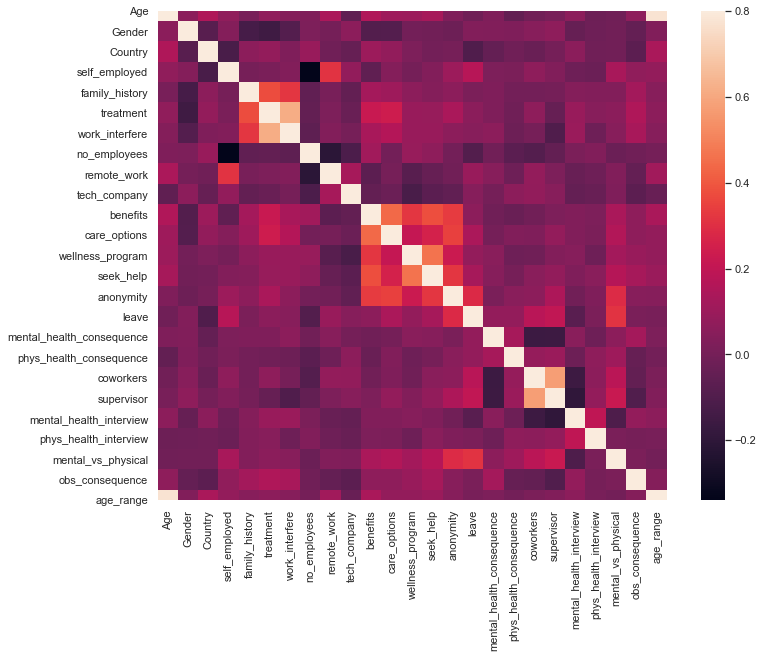

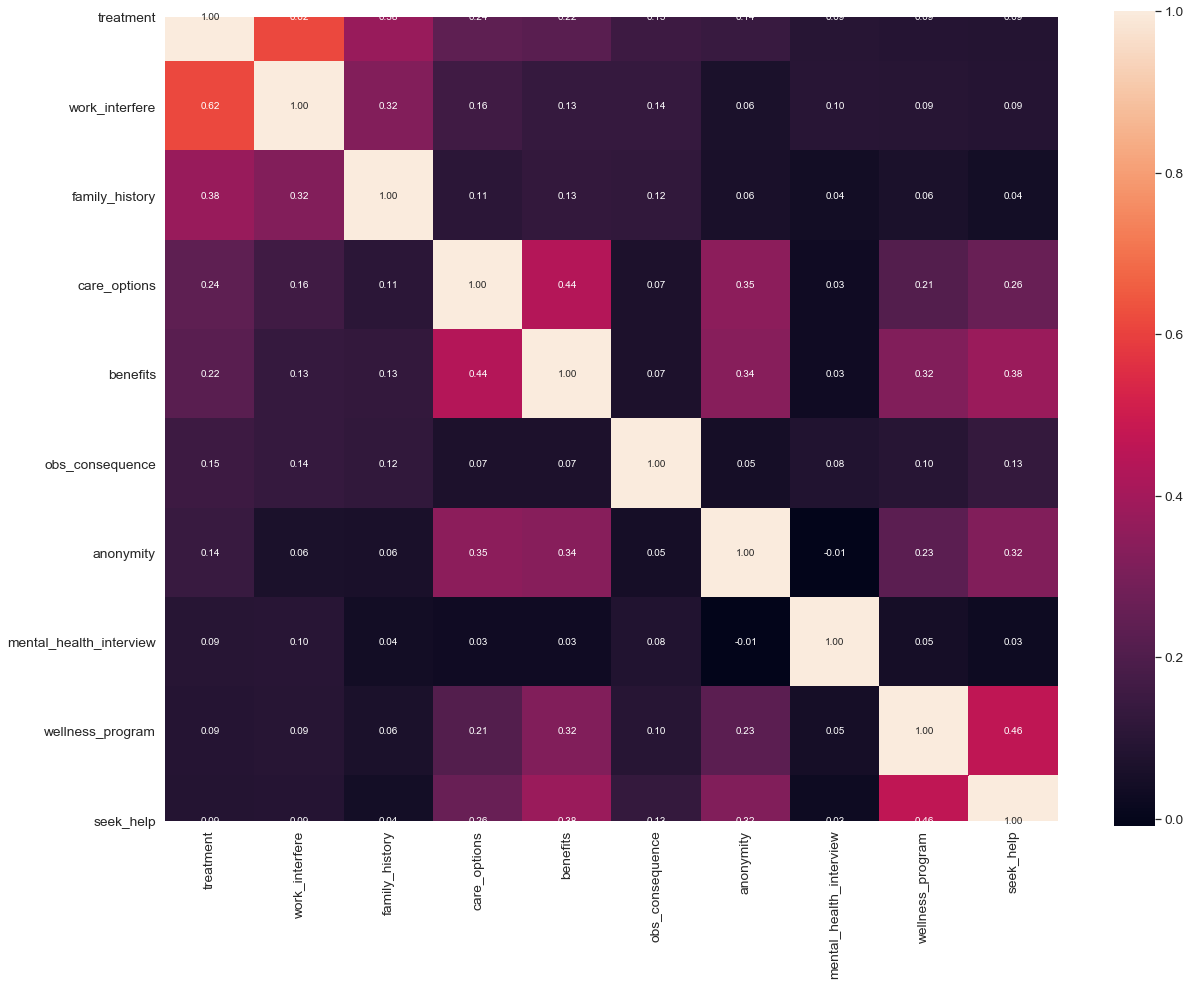

In [43]:
#Pearson correlation matrix
corrmat = df_corr.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);
plt.show()

#treatment correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'treatment')['treatment'].index
cm = np.corrcoef(df_corr[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [44]:
# Let's see how variables relate to the Country.
relcoun= df_corr.corr()
relcoun['Country'].sort_values(ascending=False)

Country                      1.000000
Age                          0.153942
age_range                    0.138678
benefits                     0.102219
no_employees                 0.096334
treatment                    0.080096
care_options                 0.076554
family_history               0.065099
mental_health_interview      0.058061
work_interfere               0.029436
wellness_program             0.024673
anonymity                    0.004720
supervisor                   0.000714
seek_help                   -0.005831
mental_vs_physical          -0.009082
phys_health_consequence     -0.012326
phys_health_interview       -0.013326
remote_work                 -0.014481
coworkers                   -0.028268
tech_company                -0.040524
mental_health_consequence   -0.042254
obs_consequence             -0.066102
Gender                      -0.078608
leave                       -0.099812
self_employed               -0.117261
Name: Country, dtype: float64

## Entropy based Feature Importance

Because we can use machine learning for this process, there is a very efficient "non-parametric" way of finding feature importance which goes beyond the linear Pearson coefficient.

It is called a Tree classifier and it works implementing a forest of decision trees which will attempt to determine what is the most important feature in the treatment of mental health.

https://towardsdatascience.com/entropy-how-decision-trees-make-decisions-2946b9c18c8

This will allow us to understand if and how "Country" plays a role in mental health.

In [45]:
# define X and y
feature_cols = ['Country','Age', 'Gender', 'family_history', 'benefits', 'care_options', 'anonymity', 'leave', 'work_interfere']
X = df_corr[feature_cols]
y = df_corr.treatment

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Create dictionaries for final graph
# Use: methodDict['Stacking'] = accuracy_score
methodDict = {}
rmseDict = ()

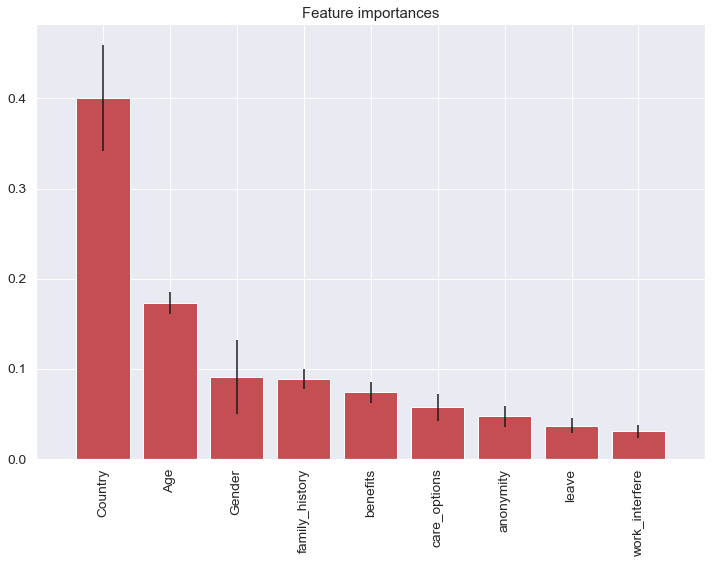

In [46]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

labels = []
for f in range(X.shape[1]):
    labels.append(feature_cols[f])      
    
# Plot the feature importances of the forest
plt.figure(figsize=(12,8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), labels, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

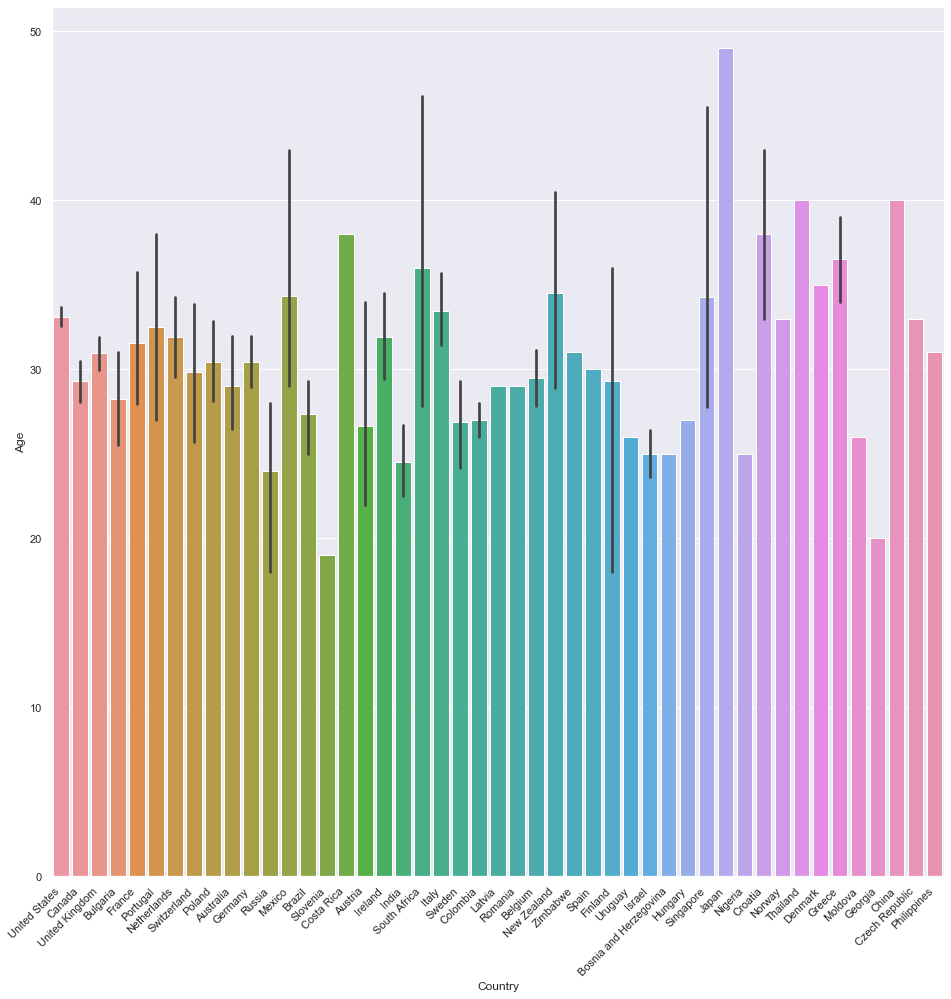

In [47]:
# Let's see how country relates to some of the most important features

# Age
sns.set(rc={'figure.figsize':(16,16)})
chart = sns.barplot(x=df_co['Country'],y=df_co['Age'])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45,horizontalalignment='right');

In [48]:
by_famH = (df_co
            .groupby(df_co['Country'])
            .filter(lambda x : len(x) > 1)
            .groupby(['Country', 'family_history'])
            .size()
            .unstack()
           )
by_famH

family_history,No,Yes
Country,,
Australia,10.0,11.0
Austria,2.0,1.0
Belgium,5.0,1.0
Brazil,4.0,2.0
Bulgaria,4.0,NaN
Canada,45.0,27.0
Colombia,2.0,NaN
Croatia,1.0,1.0
Denmark,NaN,2.0


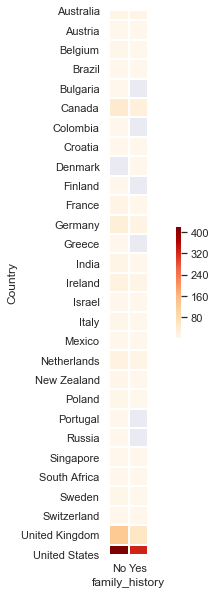

In [49]:
plt.figure(figsize=(10,10))
g = sns.heatmap(
    by_famH, 
    square=True, # make cells square
    cbar_kws={'fraction' : 0.01}, # shrink colour bar
    cmap='OrRd', # use orange/red colour map
    linewidth=1 # space between cells
)

In [50]:
# Benefits

by_benefits = (df_co
            .groupby(df_co['Country'])
            .filter(lambda x : len(x) > 1)
            .groupby(['Country', 'benefits'])
            .size()
            .unstack()
           )
by_benefits



benefits,Don't know,No,Yes
Country,,,
Australia,5.0,12.0,4.0
Austria,2.0,NaN,1.0
Belgium,2.0,2.0,2.0
Brazil,2.0,4.0,NaN
Bulgaria,1.0,3.0,NaN
Canada,22.0,21.0,29.0
Colombia,NaN,2.0,NaN
Croatia,NaN,1.0,1.0
Denmark,NaN,2.0,NaN


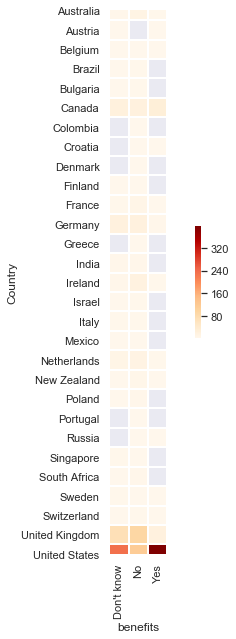

In [51]:
plt.figure(figsize=(10,10))
g = sns.heatmap(
    by_benefits, 
    square=True, # make cells square
    cbar_kws={'fraction' : 0.01}, # shrink colour bar
    cmap='OrRd', # use orange/red colour map
    linewidth=1 # space between cells
)

In [52]:
# Care Options

by_careO = (df_co
            .groupby(df_co['Country'])
            .filter(lambda x : len(x) > 1)
            .groupby(['Country', 'care_options'])
            .size()
            .unstack()
           )
by_careO


care_options,No,Not sure,Yes
Country,,,
Australia,7.0,5.0,9.0
Austria,2.0,NaN,1.0
Belgium,4.0,1.0,1.0
Brazil,4.0,NaN,2.0
Bulgaria,3.0,1.0,NaN
Canada,22.0,22.0,28.0
Colombia,1.0,NaN,1.0
Croatia,1.0,NaN,1.0
Denmark,NaN,NaN,2.0


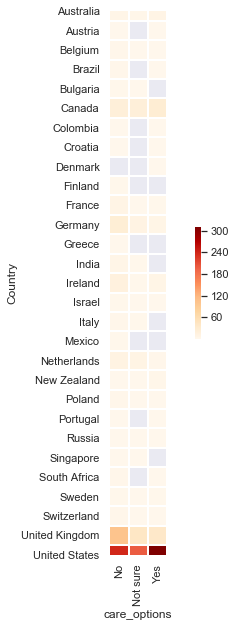

In [53]:

plt.figure(figsize=(10,10))
g = sns.heatmap(
    by_careO, 
    square=True, # make cells square
    cbar_kws={'fraction' : 0.01}, # shrink colour bar
    cmap='OrRd', # use orange/red colour map
    linewidth=1 # space between cells
)

In [54]:
# anonimity

by_anonymity = (df_co
            .groupby(df_co['Country'])
            .filter(lambda x : len(x) > 1)
            .groupby(['Country', 'anonymity'])
            .size()
            .unstack()
           )
by_anonymity

anonymity,Don't know,No,Yes
Country,,,
Australia,12.0,3.0,6.0
Austria,2.0,NaN,1.0
Belgium,3.0,2.0,1.0
Brazil,4.0,2.0,NaN
Bulgaria,3.0,1.0,NaN
Canada,45.0,5.0,22.0
Colombia,1.0,1.0,NaN
Croatia,NaN,NaN,2.0
Denmark,2.0,NaN,NaN


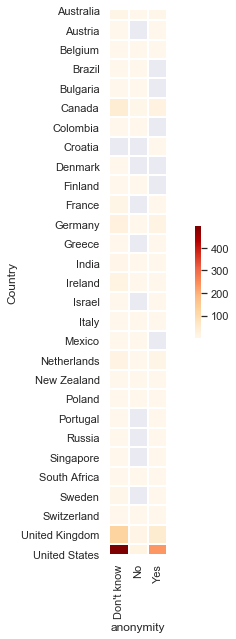

In [55]:
plt.figure(figsize=(10,10))
g = sns.heatmap(
    by_anonymity, 
    square=True, # make cells square
    cbar_kws={'fraction' : 0.01}, # shrink colour bar
    cmap='OrRd', # use orange/red colour map
    linewidth=1 # space between cells
)

In [56]:
# leave
by_leave = (df_co
            .groupby(df_co['Country'])
            .filter(lambda x : len(x) > 1)
            .groupby(['Country', 'leave'])
            .size()
            .unstack()
           )
by_leave

leave,Don't know,Somewhat difficult,Somewhat easy,Very difficult,Very easy
Country,,,,,
Australia,6.0,3.0,4.0,1.0,7.0
Austria,NaN,NaN,2.0,NaN,1.0
Belgium,2.0,NaN,2.0,1.0,1.0
Brazil,3.0,NaN,3.0,NaN,NaN
Bulgaria,2.0,NaN,1.0,NaN,1.0
Canada,26.0,10.0,18.0,9.0,9.0
Colombia,NaN,NaN,1.0,1.0,NaN
Croatia,NaN,NaN,NaN,1.0,1.0
Denmark,NaN,NaN,2.0,NaN,NaN


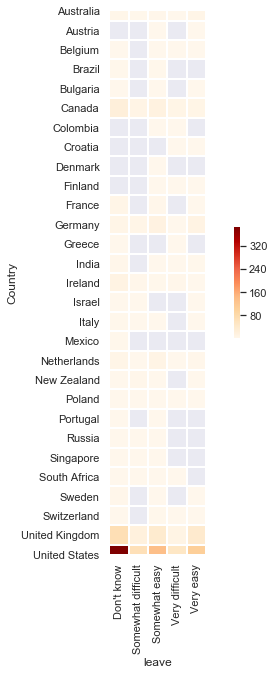

In [57]:
plt.figure(figsize=(10,10))
g = sns.heatmap(
    by_leave, 
    square=True, # make cells square
    cbar_kws={'fraction' : 0.01}, # shrink colour bar
    cmap='OrRd', # use orange/red colour map
    linewidth=1 # space between cells
)

In [58]:
# work interference
by_workint = (df_co
            .groupby(df_co['Country'])
            .filter(lambda x : len(x) > 1)
            .groupby(['Country', 'work_interfere'])
            .size()
            .unstack()
           )
by_workint

work_interfere,Don't know,Never,Often,Rarely,Sometimes
Country,,,,,
Australia,1.0,3.0,5.0,2.0,10.0
Austria,2.0,NaN,NaN,NaN,1.0
Belgium,2.0,1.0,1.0,1.0,1.0
Brazil,2.0,1.0,NaN,2.0,1.0
Bulgaria,1.0,1.0,NaN,1.0,1.0
Canada,9.0,16.0,11.0,7.0,29.0
Colombia,NaN,NaN,1.0,NaN,1.0
Croatia,NaN,NaN,NaN,NaN,2.0
Denmark,NaN,NaN,2.0,NaN,NaN


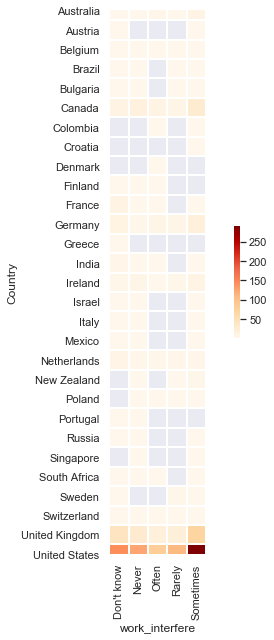

In [59]:
plt.figure(figsize=(10,10))
g = sns.heatmap(
    by_workint, 
    square=True, # make cells square
    cbar_kws={'fraction' : 0.01}, # shrink colour bar
    cmap='OrRd', # use orange/red colour map
    linewidth=1 # space between cells
)